In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

from typing import Optional
from typing_extensions import Literal

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

device = 'cpu'

/Users/binom/.anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class GeneratorMNISTWGAN(nn.Module):
    def __init__(self, lat_size):
        super(GeneratorMNISTWGAN, self).__init__()

        img_size=28
        
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(
            nn.Linear(lat_size, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128 * self.init_size ** 2)
        )

        self.conv_blocks = nn.Sequential(
            #nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            #nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            #nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z, foo=None):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class DiscriminatorMNISTWGAN(nn.Module):
    def __init__(self):
        super(DiscriminatorMNISTWGAN, self).__init__()

        img_size = 28
        
        def discriminator_block(in_filters, out_filters, bn=False):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2), nn.Dropout2d(0.0)]
            #if bn:
            #    block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512, 1, bias=False))

    def forward(self, img, foo=None):
        for p in self.parameters():
           p.data.clamp_(-0.06, 0.06)
        
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [8]:
gen_mnist = GeneratorMNISTWGAN(2)
gen_mnist.to(device)

discr_mnist = DiscriminatorMNISTWGAN()
discr_mnist.to(device)

prior_mnist = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

In [30]:
gen_mnist.load_state_dict(torch.load('wgan_2d.ckpt')[0])
discr_mnist.load_state_dict(torch.load('wgan_2d.ckpt')[1])
gen_mnist.eval()
discr_mnist.eval()

DiscriminatorMNISTWGAN(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout2d(p=0.0, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout2d(p=0.0, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout2d(p=0.0, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout2d(p=0.0, inplace=False)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=False)
  )
)

In [31]:
def get_energy_vanilla_gan(z):
  return (-discr_mnist(gen_mnist(z)).squeeze() - prior_mnist.log_prob(z).squeeze())

def target_dens(x):
    """
    returns the value of a target density - mixture of the 3 gaussians 
    """
    x = torch.FloatTensor(x)[None, :]
    return np.exp(-get_energy_vanilla_gan(x).detach().cpu().numpy())

def log_target_dens(x):
    """
    returns the value of a target density - mixture of the 3 gaussians 
    """
    x = torch.FloatTensor(x)[None, :]
    return -get_energy_vanilla_gan(x).detach().cpu().numpy()

def grad_target_dens(x):
    """
    returns the gradient of log-density 
    """
    x = torch.FloatTensor(x)[None, :]
    x.requires_grad_(True)
    external_grad = torch.tensor(1.)
    (-get_energy_vanilla_gan(x)).backward(gradient=external_grad)
    return x.grad.data.detach().cpu().numpy()[0]

def logp_mala(y,z,gamma):
    return -1/(4*gamma)*(np.sum(y - z - gamma*grad_target_dens(z))**2)

def discretesampling(w):
    u = np.random.rand()
    bins = np.cumsum(w)
    return np.digitize(u,bins)

def log_dens_isir(x,sigma):
    """
    compute log-density of a normal distributio nwith standard deviation sigma**2
    """
    return -np.sum(x**2)/(2*sigma**2)

In [32]:
grad_target_dens([0, 0])

array([-6.9691534, -2.0166214], dtype=float32)

In [33]:
def mala(x0,gamma,n):
    """
    function to perform n times MALA step 
    """
    #generate proposals
    x_cur = x0
    for i in range(n):
        y = x_cur + gamma*grad_target_dens(x_cur) + np.sqrt(2*gamma)*np.random.randn(2)
        #compute accept-reject
        log_prob_accept = np.minimum(0.0, log_target_dens(y) + logp_mala(x_cur,y,gamma) - log_target_dens(x_cur) - logp_mala(y,x_cur,gamma))
        #generate uniform distribution
        unif = np.log(np.random.uniform())
        indic_acc = (log_prob_accept > unif)
        global n_accepts
        n_accepts += indic_acc
        x_cur = indic_acc*y + (1-indic_acc)*x_cur
    return x_cur

In [34]:
def i_sir(x0,N,sigma_isir):
    """
    function to sample with N-particles version of i-SIR
    args:
        N_part - number of particles, integer;
        x0 - current i-sir particle;
    return:
        x_next - selected i-sir particle
    """
    #generate proposals
    proposals = sigma_isir*np.random.randn(N,2)
    #put current particles
    proposals[0,:] = x0
    #compute importance weights
    logw = np.zeros(N,dtype=float)
    for i in range(N):
        logw[i] = log_target_dens(proposals[i,:]) - log_dens_isir(proposals[i,:],sigma_isir)
    maxLogW = np.max(logw)
    uw = np.exp(logw-maxLogW)
    w = uw / np.sum(uw)
    #sample selected index
    idx = discretesampling(w)
    #retur seleted particle
    return proposals[idx]

In [35]:
def ex2_mcmc(x0,N,sigma_isir,gamma,n_steps_mala):
    """
    function to sample with N-particles vrsion of i-SIR using MALA as a rejuvenation kernel with step size gamma
    """
    #generate proposals
    proposals = sigma_isir*np.random.randn(N,2)
    #put current particles
    proposals[0,:] = x0
    #compute importance weights
    logw = np.zeros(N,dtype=float)
    for i in range(N):
        logw[i] = log_target_dens(proposals[i,:]) - log_dens_isir(proposals[i,:],sigma_isir)
    maxLogW = np.max(logw)
    uw = np.exp(logw-maxLogW)
    w = uw / np.sum(uw)
    #sample selected index
    idx = discretesampling(w)
    #return seleted particle
    x_new = proposals[idx]
    #perform rejuvenation step
    x_rej = mala(x_new,gamma,n_steps_mala)
    return x_rej

### Put parameters of the target density

In [36]:
a = 2.0
mu = a*np.array([[0.0,1.0],[np.sqrt(3)/2,-0.5],[-np.sqrt(3)/2,-0.5]])
sigma = 1.0
print(mu.shape)

(3, 2)


100%|█████████████████████████████████████████| 704/704 [01:27<00:00,  8.01it/s]


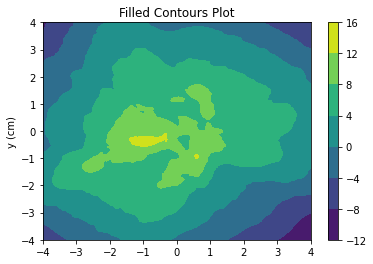

In [37]:
N_pts = 300
xlist = np.linspace(-2*a, 2*a, N_pts)
ylist = np.linspace(-2*a, 2*a, N_pts)
X, Y = np.meshgrid(xlist, ylist)
points = np.zeros((X.shape[0],X.shape[1], 2),dtype=float)
points[:, :, 0] = X
points[:, :, 1] = Y

points = points.reshape(-1, 2)

batch_size = 128

dens_vals = []
for i in tqdm.tqdm(range(points.shape[0] // batch_size + (1 if points.shape[0] % batch_size else 0))):
    z = torch.FloatTensor(points[i * batch_size: (i + 1) * batch_size]).to(device)
    dens_vals.append(-get_energy_vanilla_gan(z).detach().cpu().numpy())

dens_vals = np.concatenate(dens_vals).reshape(N_pts, N_pts)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [38]:
N_samples = 100
N_particles = 3
gamma = 0.2
N_steps_mala = 3
sigma_isir = 3.0

### sample i-sir
Samples_isir = np.zeros((N_samples,2),dtype = float)
x0 = np.zeros(2)
x_cur = x0
np.random.seed(42)
for i in range(N_samples):
    x_cur = i_sir(x_cur,N_particles,sigma_isir)
    Samples_isir[i] = x_cur

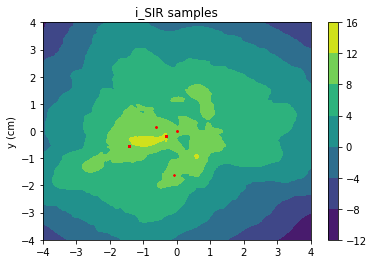

In [39]:

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals)
fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(Samples_isir[:,0],Samples_isir[:,1], s=1, c='r')
ax.set_title('i_SIR samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [40]:
### sample mala
Samples_mala = np.zeros((N_samples,2),dtype = float)
x0 = np.zeros(2)
x_cur = x0
n_accepts = 0
np.random.seed(42)

for i in range(N_samples):
    x_cur = mala(x_cur,gamma,N_steps_mala)
    Samples_mala[i] = x_cur
print("number accepts = ",n_accepts)

number accepts =  35


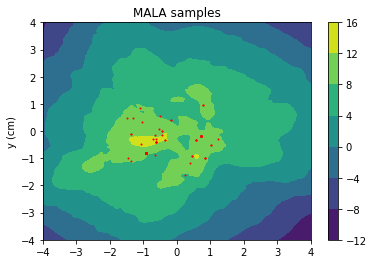

In [41]:

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals)
fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(Samples_mala[:,0],Samples_mala[:,1], s=1, c='r')
ax.set_title('MALA samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [42]:
### sample ex2mcmc
Samples_ex2 = np.zeros((N_samples,2),dtype = float)
x0 = np.zeros(2)
x_cur = x0
n_accepts = 0
np.random.seed(42)

for i in range(N_samples):
    x_cur = ex2_mcmc(x_cur,N_particles,sigma_isir,gamma,N_steps_mala)
    Samples_ex2[i] = x_cur
print("number accepts = ",n_accepts)

number accepts =  44


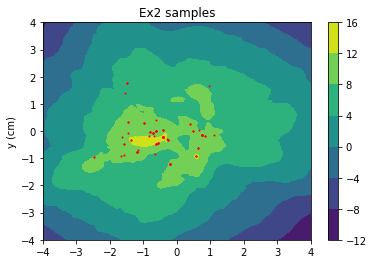

In [43]:

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, dens_vals)
fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(Samples_ex2[:,0],Samples_ex2[:,1], s=1, c='r')
ax.set_title('Ex2 samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Plot all 3 pictures together

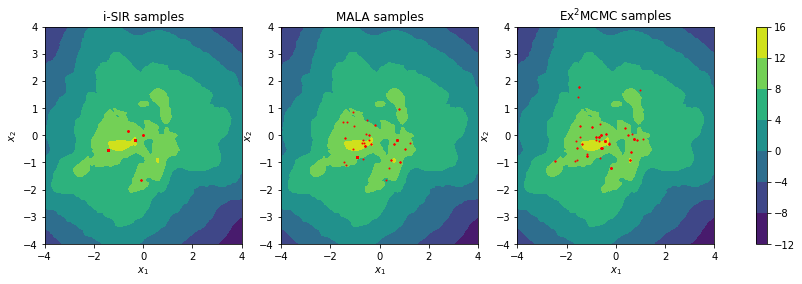

In [44]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
im = ax[0].contourf(X, Y, dens_vals)
im = ax[1].contourf(X, Y, dens_vals)
im = ax[2].contourf(X, Y, dens_vals)
fig.colorbar(im, ax=ax.flat) # Add a colorbar to a plot
#i-sir plots
ax[0].scatter(Samples_isir[:,0],Samples_isir[:,1], s=1, c='r')
ax[0].set_title('i-SIR samples')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
#mala samples
ax[1].scatter(Samples_mala[:,0],Samples_mala[:,1], s=1, c='r')
ax[1].set_title('MALA samples')
ax[1].set_xlabel('$x_1$')
ax[1].set_ylabel('$x_2$')
#ex2-mcmc samples
ax[2].scatter(Samples_ex2[:,0],Samples_ex2[:,1], s=1, c='r')
ax[2].set_title('Ex$^2$MCMC samples')
ax[2].set_xlabel('$x_1$')
ax[2].set_ylabel('$x_2$')
plt.savefig("toy_samples_2d_gaus.pdf", format="pdf", bbox_inches="tight") 
plt.show()

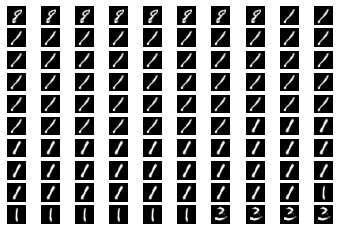

In [45]:
sampled_mnist = gen_mnist(torch.FloatTensor(Samples_isir))

for i in range(100):
  plt.subplot(10, 10, i + 1)
  plt.axis('off')
  plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')

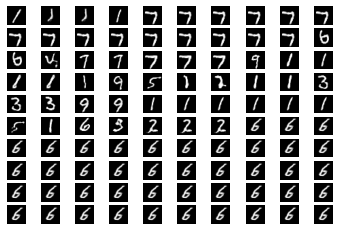

In [46]:
sampled_mnist = gen_mnist(torch.FloatTensor(Samples_mala))

for i in range(100):
  plt.subplot(10, 10, i + 1)
  plt.axis('off')
  plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')

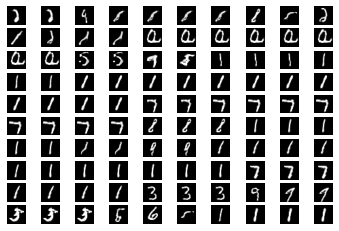

In [47]:
sampled_mnist = gen_mnist(torch.FloatTensor(Samples_ex2))

for i in range(100):
  plt.subplot(10, 10, i + 1)
  plt.axis('off')
  plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')

In [27]:
Samples_isir.shape

(100, 2)

In [28]:
Samples_mala.shape

(100, 2)

In [29]:
Samples_ex2.shape

(100, 2)